# Candy Production

Analysis/prediction of candy production timeseries dataset from FRED

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10
sns.set(context='notebook', rc={'figure.figsize': (8, 5)})

In [2]:
!cat candy_production.csv

observation_date,IPG3113N
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100
1972-06-01,67.6467
1972-07-01,69.0429
1972-08-01,70.8370
1972-09-01,75.0462
1972-10-01,106.9289
1972-11-01,105.5962
1972-12-01,105.9673
1973-01-01,91.2997
1973-02-01,77.2700
1973-03-01,69.6110
1973-04-01,70.2986
1973-05-01,71.6822
1973-06-01,74.8635
1973-07-01,72.0464
1973-08-01,73.1748
1973-09-01,80.5915
1973-10-01,102.9200
1973-11-01,109.2524
1973-12-01,105.2210
1974-01-01,88.6985
1974-02-01,83.6098
1974-03-01,77.2300
1974-04-01,67.3209
1974-05-01,74.6196
1974-06-01,79.5858
1974-07-01,66.0568
1974-08-01,71.1864
1974-09-01,70.1750
1974-10-01,99.2212
1974-11-01,101.1201
1974-12-01,86.8930
1975-01-01,67.0117
1975-02-01,52.6964
1975-03-01,50.6689
1975-04-01,59.7613
1975-05-01,60.8277
1975-06-01,63.3629
1975-07-01,62.3089
1975-08-01,66.9021
1975-09-01,66.3200
1975-10-01,96.3411
1975-11-01,105.6285
1975-12-01,102.1819
1976-01-01,87.9578
1976-02-01,75.1878
1976-03-01,62.0

In [3]:
df = pd.read_csv('candy_production.csv', parse_dates=True, index_col=0)
df.rename(columns={'IPG3113N': 'production'}, inplace=True)

In [4]:
df

,production
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100
...,...
2017-04-01,107.4288
2017-05-01,101.9209
2017-06-01,104.2022


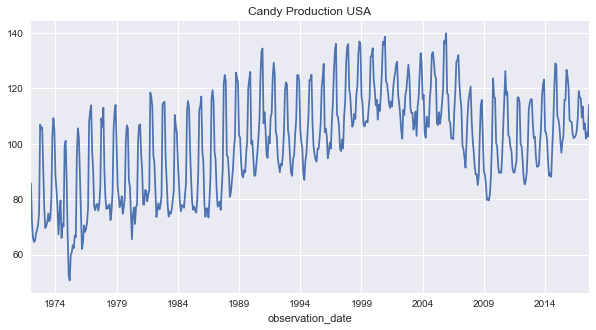

In [5]:
ax = df.plot(figsize=(10, 5), title='Candy Production USA', legend=False)
ax.get_figure().savefig('candy_production.pdf', dpi=300)

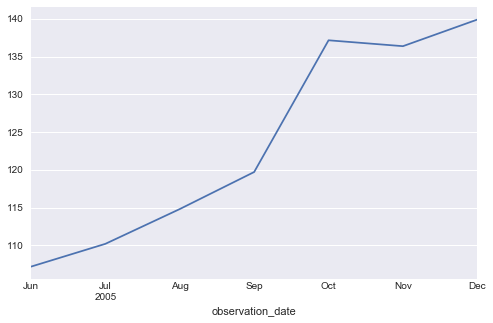

In [6]:
ax = df['2005-06':'2005-12'].plot(legend=False)

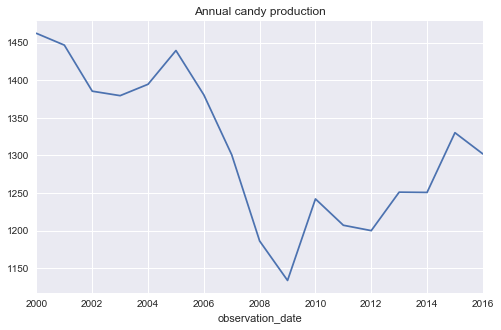

In [7]:
# AS = year start frequency
# http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
annual = df.resample('AS').sum()
ax = annual['2000':'2016'].plot(legend=False, title='Annual candy production')

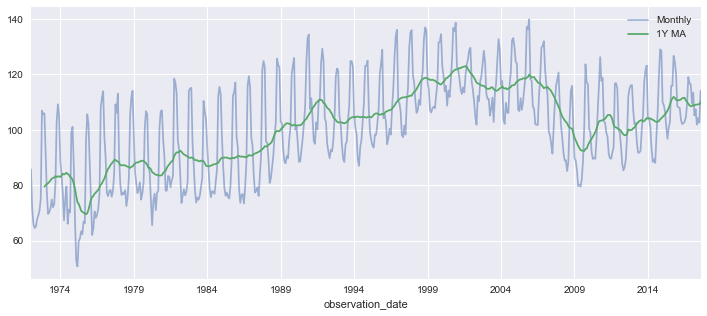

In [8]:
df.production.plot(label='Monthly', figsize=(12, 5), alpha=0.5, legend=True)
ax = df.production.rolling(12).mean().plot(label='1Y MA', legend=True)

/usr/local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


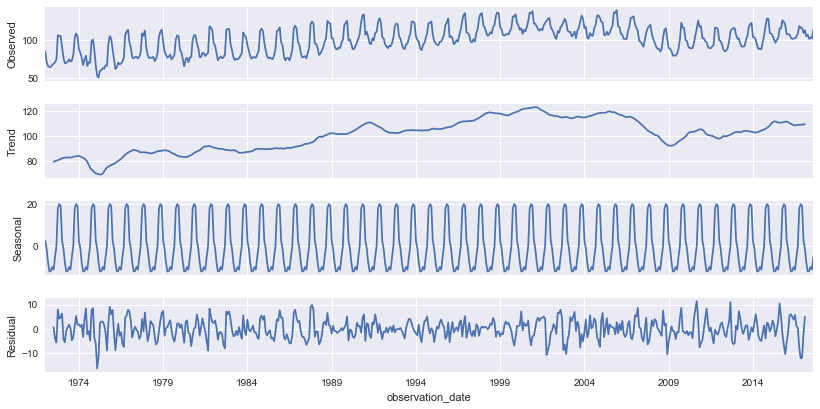

In [9]:
import statsmodels.api as sm

f = sm.tsa.seasonal_decompose(df).plot()
f.set_size_inches(12, 6)

In [10]:
mod = sm.tsa.SARIMAX(df, trend='c', order=(1, 1, 1), seasonal_order=(0, 1, 2, 12))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         production   No. Observations:                  548
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -1472.159
Date:                            Thu, 02 Nov 2017   AIC                           2956.318
Time:                                    15:36:39   BIC                           2982.156
Sample:                                01-01-1972   HQIC                          2966.417
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.008      0.078      0.938      -0.015       0.016
ar.L1          0.5478      0.079      6.951      0.000       0.393       0.702
ma.L1         -0.8150      0.056    -14.539      0.000      -0.925      -0.705
ma.S.L12      -0.6494      0.039    -16.566      0.000      -0.726      -0.573
ma.S.L24      -0.1188      0.040     -3.002      0.003      -0.196      -0.041
sigma2        14.1060      0.735     19.181      0.000      12.665      15.547
===================================================================================
Ljung-Box (Q):                      108.25   Jarque-Bera (JB):                20.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.22
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

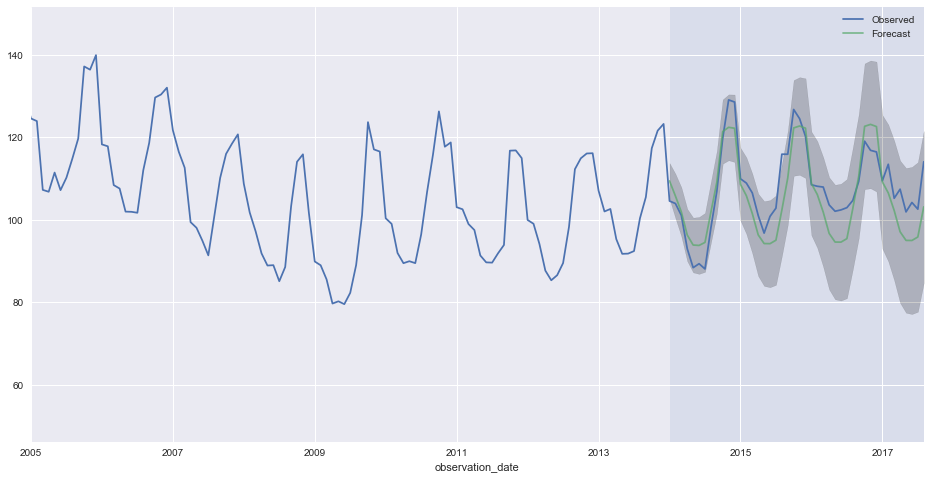

In [11]:
pred = res.get_prediction(start='2014-01-01', dynamic='2014-01-01')
pred_ci = pred.conf_int(alpha=0.25)

ax = df.production.plot(label='Observed', legend=True, figsize=(16, 8))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, legend=True)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlim(pd.Timestamp('2005-01-01'), df.index.max())

ylim = list(ax.get_ylim())
ylim[1] *= 1.05
ax.fill_betweenx(ylim, pd.Timestamp('2014-01-01'), df.index.max(), alpha=.1, zorder=-1)
_ = ax.set_ylim(ylim)